# Analyzing interstellar reddening and calculating synthetic photometry

## Authors

Kristen Larson, Lia Corrales, Stephanie T. Douglas, Kelle Cruz

Input from Emir Karamehmetoglu, Pey Lian Lim, Karl Gordon, Kevin Covey

## Learning Goals
- Investigate extinction curve shapes
- Deredden spectral energy distributions and spectra
- Calculate photometric extinction and reddening
- Calculate synthetic photometry for a dust-reddened star by combining `dust_extinction` and `synphot`
- Convert from frequency to wavelength with `astropy.unit` equivalencies
- Unit support for plotting with `astropy.visualization`


## Keywords
dust extinction, synphot, astroquery, units, photometry, extinction, physics, observational astronomy

## Companion Content

* [Bessell & Murphy (2012)](https://ui.adsabs.harvard.edu/#abs/2012PASP..124..140B/abstract)



## Summary

In this tutorial, we will look at some extinction curves from the literature, use one of those curves to deredden an observed spectrum, and practice invoking a background source flux in order to calculate magnitudes from an extinction model.

The primary libraries we'll be using are [dust_extinction](https://dust-extinction.readthedocs.io/en/latest/) and [synphot](https://synphot.readthedocs.io/en/latest/), which are [Astropy affiliated packages](https://www.astropy.org/affiliated/). 

We recommend installing the two packages in this fashion:
```
pip install synphot
pip install dust_extinction
```
This tutorial requires v0.7 or later of `dust_extinction`. To ensure that all commands work properly, make sure you have the correct version installed. If you have v0.6 or earlier installed, run the following command to upgrade
```
pip install dust_extinction --upgrade
```

In [1]:
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import astropy.units as u
from astropy.table import Table
from dust_extinction.parameter_averages import CCM89, F99
from synphot import units, config
from synphot import SourceSpectrum,SpectralElement,Observation,ExtinctionModel1D
from synphot.models import BlackBodyNorm1D
from synphot.spectrum import BaseUnitlessSpectrum
from synphot.reddening import ExtinctionCurve
from astroquery.simbad import Simbad
from astroquery.mast import Observations
import astropy.visualization

# Introduction

Dust in the interstellar medium (ISM) extinguishes background starlight.  The wavelength dependence of the extinction is such that short-wavelength light is extinguished more than long-wavelength light, and we call this effect *reddening*.

If you're new to extinction, here is a brief introduction to the types of quantities involved.
The fractional change to the flux of starlight is 
$$
\frac{dF_\lambda}{F_\lambda} = -\tau_\lambda
$$

where $\tau$ is the optical depth and depends on wavelength.  Integrating along the line of sight, the resultant flux is an exponential function of optical depth,
$$
\tau_\lambda = -\ln\left(\frac{F_\lambda}{F_{\lambda,0}}\right).
$$

With an eye to how we define magnitudes, we usually change the base from $e$ to 10,  
$$
\tau_\lambda = -2.303\log\left(\frac{F_\lambda}{F_{\lambda,0}}\right),
$$

and define an extinction $A_\lambda = 1.086 \,\tau_\lambda$ so that
$$
A_\lambda = -2.5\log\left(\frac{F_\lambda}{F_{\lambda,0}}\right).
$$


There are two basic take-home messages from this derivation:

* Extinction introduces a multiplying factor $10^{-0.4 A_\lambda}$ to the flux.
* Extinction is defined relative to the flux without dust, $F_{\lambda,0}$.


Once astropy and the affiliated packages are installed, we can import from them as needed:

# Example 1: Investigate Extinction Models

The `dust_extinction` package provides various models for extinction $A_\lambda$ normalized to $A_V$.  The shapes of normalized curves are relatively (and perhaps surprisingly) uniform in the Milky Way.  The little variation that exists is often parameterized by the ratio of extinction ($A_V$) to reddening  in the blue-visual ($E_{B-V}$),
$$
R_V \equiv \frac{A_V}{E_{B-V}}
$$

where $E_{B-V}$ is differential extinction $A_B-A_V$.  In this example, we show the $R_V$-parameterization for the Clayton, Cardelli, & Mathis (1989, CCM) and the Fitzpatrick (1999) models. [More model options are available in the `dust_extinction` documentation.](https://dust-extinction.readthedocs.io/en/latest/dust_extinction/model_flavors.html)

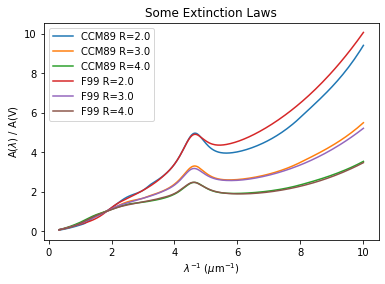

In [2]:
# Create wavelengths array.
wav = np.arange(0.1, 3.0, 0.001)*u.micron

for model in [CCM89, F99]:
    for R in (2.0,3.0,4.0):
        # Initialize the extinction model
        ext = model(Rv=R)
        plt.plot(1/wav, ext(wav), label=model.name+' R='+str(R))
        
plt.xlabel('$\lambda^{-1}$ ($\mu$m$^{-1}$)')
plt.ylabel('A($\lambda$) / A(V)')
plt.legend(loc='best')
plt.title('Some Extinction Laws')
plt.show()

Astronomers studying the ISM often display extinction curves against inverse wavelength (wavenumber) to show the ultraviolet variation, as we do here.  Infrared extinction varies much less and approaches zero at long wavelength in the absence of wavelength-independent, or grey, extinction.

# Example 2: Deredden a Spectrum

Here we deredden (unextinguish) the IUE ultraviolet spectrum and optical photometry of the star $\rho$ Oph (HD 147933).

First, we will use astroquery to fetch the archival [IUE spectrum from MAST](https://archive.stsci.edu/iue/):

In [3]:
download_dir = pathlib.Path('~/.astropy/cache/astroquery/Mast').expanduser()
download_dir.mkdir(exist_ok=True)

obsTable = Observations.query_object("HD 147933", radius="1 arcsec")
obsTable_spec = obsTable[obsTable['dataproduct_type'] == 'spectrum']
obsTable_spec

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str7,str11,str12,str13,str6,str16,str16,str21,str32,str31,float64,float64,str8,str19,int64,float64,float64,float64,float64,float64,str117,float64,str25,str6,int64,str23309,str137,str137,str6,bool,float64,str8,float64
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05490,246.396176503177,-23.4459596019354,spectrum,Theodore P. Snow,2,46135.7773264,46135.7787093,119.48,185000100000.0,334994200000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396176503177 -23.4459596019354 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05490.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05490.mxhi.gz,PUBLIC,--,5885.0,349209,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05491,246.39607641879502,-23.4459600461498,spectrum,Theodore P. Snow,2,46135.8042014,46135.8083623,359.506,185000500000.0,334994900000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396076418795 -23.4459600461498 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05491.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05491.mxhi.gz,PUBLIC,--,5885.0,349210,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05492,246.396176503177,-23.4459596019354,spectrum,Theodore P. Snow,2,46135.830544,46135.8319269,119.48,185004300000.0,334993600000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396176503177 -23.4459596019354 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05492.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05492.mxhi.gz,PUBLIC,--,5885.0,349211,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05493,246.396176503177,-23.4459596019354,spectrum,Theodore P. Snow,2,46135.8570949,46135.8609098,329.605,185000400000.0,334994500000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396176503177 -23.4459596019354 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05493.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05493.mxhi.gz,PUBLIC,--,5885.0,349212,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05494,246.39607641879502,-23.4459600461498,spectrum,Theodore P. Snow,2,46135.8850463,46135.8864292,119.48,185004200000.0,334993300000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396076418795 -23.4459600461498 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05494.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05494.mxhi.gz,PUBLIC,--,5885.0,349213,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05495,246.396176503177,-23.4459596019354,spectrum,Theodore P. Snow,2,46135.9142708,46135.9180857,329.605,185000900000.0,334995500000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396176503177 -23.4459596019354 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05495.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05495.mxhi.gz,PUBLIC,--,5885.0,349214,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05496,246.396176503177,-23.4459596019354,spectrum,Theodore P. Snow,2,46135.9434838,46135.944696,104.735,185000400000.0,334994400000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396176503177 -23.4459596019354 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05496.gif,http://archive.stsci.edu/missi

In [4]:
obsids = obsTable_spec[39]['obsid']
dataProductsByID = Observations.get_product_list(obsids)
manifest = Observations.download_products(dataProductsByID, 
                                          download_dir=str(download_dir))

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


We read the downloaded files into an astropy table:

In [5]:
t_lwr = Table.read(download_dir / 'mastDownload/IUE/lwr05639/lwr05639mxlo_vo.fits')
print(t_lwr)

      WAVE [562]              FLUX [562]         ... QUALITY [562]
       Angstrom         erg / (Angstrom cm2 s)   ...              
--------------------- -------------------------- ... -------------
1851.4327 .. 3348.901 2.08651e-10 .. 7.39839e-11 ...       0 .. 16


The `.quantity` extension in the next lines will read the Table columns into Quantity vectors.  Quantities keep the units of the Table column attached to the numpy array values.

In [6]:
wav_UV = t_lwr['WAVE'][0,].quantity
UVflux = t_lwr['FLUX'][0,].quantity

Now, we use astroquery again to fetch photometry from Simbad to go with the IUE spectrum:

In [7]:
custom_query = Simbad()
custom_query.add_votable_fields('fluxdata(U)','fluxdata(B)','fluxdata(V)')
phot_table=custom_query.query_object('HD 147933')
Umag=phot_table['FLUX_U']
Bmag=phot_table['FLUX_B']
Vmag=phot_table['FLUX_V']

To convert the photometry to flux, we look up some [properties of the photometric passbands](http://ned.ipac.caltech.edu/help/photoband.lst), including the flux of a magnitude zero star through the each passband, also known as the zero-point of the passband.

In [8]:
wav_U = 0.3660 * u.micron 
zeroflux_U_nu = 1.81E-23 * u.Watt/(u.m*u.m*u.Hz)
wav_B = 0.4400 * u.micron
zeroflux_B_nu = 4.26E-23 * u.Watt/(u.m*u.m*u.Hz)
wav_V = 0.5530 * u.micron
zeroflux_V_nu = 3.64E-23 * u.Watt/(u.m*u.m*u.Hz)

The zero-points that we found for the optical passbands are not in the same units as the IUE fluxes.  To make matters worse, the zero-point fluxes are $F_\nu$ and the IUE fluxes are $F_\lambda$.  To convert between them, the wavelength is needed.  Fortunately, astropy provides an easy way to make the conversion with *equivalencies*:

In [9]:
zeroflux_U = zeroflux_U_nu.to(u.erg/u.AA/u.cm/u.cm/u.s, 
                              equivalencies=u.spectral_density(wav_U))
zeroflux_B = zeroflux_B_nu.to(u.erg/u.AA/u.cm/u.cm/u.s, 
                              equivalencies=u.spectral_density(wav_B))
zeroflux_V = zeroflux_V_nu.to(u.erg/u.AA/u.cm/u.cm/u.s, 
                              equivalencies=u.spectral_density(wav_V))

Now we can convert from photometry to flux using the definition of magnitude:
$$
F=F_0\ 10^{-0.4\, m}
$$

In [10]:
Uflux = zeroflux_U * 10.**(-0.4*Umag)
Bflux = zeroflux_B * 10.**(-0.4*Bmag)
Vflux = zeroflux_V * 10.**(-0.4*Vmag)

Using astropy quantities allow us to take advantage of astropy's unit support in plotting. [Calling `astropy.visualization.quantity_support` explicitly turns the feature on.](http://docs.astropy.org/en/stable/units/quantity.html#plotting-quantities)  Then, when quantity objects are passed to matplotlib plotting functions, the axis labels are automatically labeled with the unit of the quantity.  In addition, quantities are converted automatically into the same units when combining multiple plots on the same axes.


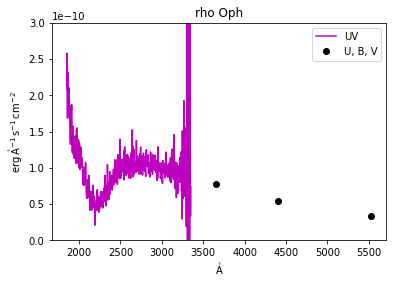

In [11]:
astropy.visualization.quantity_support()

plt.plot(wav_UV,UVflux,'m',label='UV')
plt.plot(wav_V,Vflux,'ko',label='U, B, V')
plt.plot(wav_B,Bflux,'ko')
plt.plot(wav_U,Uflux,'ko')
plt.legend(loc='best')
plt.ylim(0,3E-10)
plt.title('rho Oph')
plt.show()

Finally, we initialize the extinction model, choosing values $R_V = 5$ and $E_{B-V} = 0.5$.  This star is famous in the ISM community for having large-$R_V$ dust in the line of sight.

In [12]:
Rv = 5.0  # Usually around 3, but about 5 for this star.
Ebv = 0.5
ext = F99(Rv=Rv)

To extinguish (redden) a spectrum, multiply by the `ext.extinguish` function.  To unextinguish (deredden), divide by the same `ext.extinguish`, as we do here:

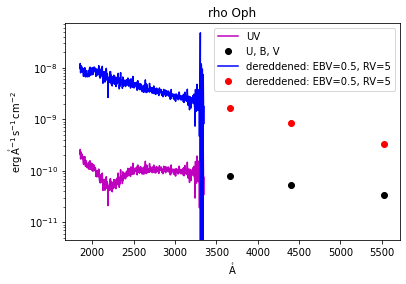

In [13]:
plt.semilogy(wav_UV,UVflux,'m',label='UV')
plt.semilogy(wav_V,Vflux,'ko',label='U, B, V')
plt.semilogy(wav_B,Bflux,'ko')
plt.semilogy(wav_U,Uflux,'ko')

plt.semilogy(wav_UV,UVflux/ext.extinguish(wav_UV,Ebv=Ebv),'b',
             label='dereddened: EBV=0.5, RV=5')
plt.semilogy(wav_V,Vflux/ext.extinguish(wav_V,Ebv=Ebv),'ro',
             label='dereddened: EBV=0.5, RV=5')
plt.semilogy(wav_B,Bflux/ext.extinguish(wav_B,Ebv=Ebv),'ro')
plt.semilogy(wav_U,Uflux/ext.extinguish(wav_U,Ebv=Ebv),'ro')

plt.legend(loc='best')
plt.title('rho Oph')
plt.show()

Notice that, by dereddening the spectrum, the absorption feature at 2175 Angstrom is removed.  This feature can also be seen as the prominent bump in the extinction curves in Example 1.  That we have smoothly removed the 2175 Angstrom feature suggests that the values we chose, $R_V = 5$ and $E_{B-V} = 0.5$, are a reasonable model for the foreground dust.

Those experienced with dereddening should notice that that `dust_extinction` returns $A_\lambda/A_V$, while other routines like the IDL fm_unred procedure often return $A_\lambda/E_{B-V}$ by default and need to be divided by $R_V$ in order to compare directly with `dust_extinction`.

# Example 3: Calculate Color Excess with `synphot`

Calculating broadband *photometric* extinction is harder than it might look at first.  All we have to do is look up $A_\lambda$ for a particular passband, right?  Under the right conditions, yes.  In general, no.

Remember that we have to integrate over a passband to get synthetic photometry,
$$
A = -2.5\log\left(\frac{\int W_\lambda F_{\lambda,0} 10^{-0.4A_\lambda} d\lambda}{\int W_\lambda F_{\lambda,0} d\lambda} \right),
$$

where $W_\lambda$ is the fraction of incident energy transmitted through a filter.  See the detailed appendix in [Bessell & Murphy (2012)](https://ui.adsabs.harvard.edu/#abs/2012PASP..124..140B/abstract)
 for an excellent review of the issues and common misunderstandings in synthetic photometry.

There is an important point to be made here. The expression above does not simplify any further. Strictly speaking, it is impossible to convert spectral extinction $A_\lambda$ into a magnitude system without knowing the wavelength dependence of the source's original flux across the filter in question.  As a special case, if we assume that the source flux is constant in the band (i.e. $F_\lambda = F$), then we can cancel these factors out from the integrals, and extinction in magnitudes becomes the weighted average of the extinction factor across the filter in question. In that special case, $A_\lambda$ at $\lambda_{\rm eff}$ is a good approximation for magnitude extinction.

In this example, we will demonstrate the more general calculation of photometric extinction.  We use a blackbody curve for the flux before the dust, apply an extinction curve, and perform synthetic photometry to calculate extinction and reddening in a magnitude system.


First, let's get the filter transmission curves:

In [14]:
# Optional, for when the STScI ftp server is not answering:
root_url = 'http://ssb.stsci.edu/trds/'
config.conf.vega_file = root_url + 'calspec/alpha_lyr_stis_010.fits'
config.conf.johnson_u_file = root_url + 'comp/nonhst/johnson_u_004_syn.fits'
config.conf.johnson_b_file = root_url + 'comp/nonhst/johnson_b_004_syn.fits'
config.conf.johnson_v_file = root_url + 'comp/nonhst/johnson_v_004_syn.fits'
config.conf.johnson_r_file = root_url + 'comp/nonhst/johnson_r_003_syn.fits'
config.conf.johnson_i_file = root_url + 'comp/nonhst/johnson_i_003_syn.fits'
config.conf.bessel_j_file = root_url + 'comp/nonhst/bessell_j_003_syn.fits'
config.conf.bessel_h_file = root_url + 'comp/nonhst/bessell_h_004_syn.fits'
config.conf.bessel_k_file = root_url + 'comp/nonhst/bessell_k_003_syn.fits'

u_band = SpectralElement.from_filter('johnson_u')
b_band = SpectralElement.from_filter('johnson_b')
v_band = SpectralElement.from_filter('johnson_v')
r_band = SpectralElement.from_filter('johnson_r')
i_band = SpectralElement.from_filter('johnson_i')
j_band = SpectralElement.from_filter('bessel_j')
h_band = SpectralElement.from_filter('bessel_h')
k_band = SpectralElement.from_filter('bessel_k')

If you are running this with your own python, see the [synphot documentation](https://synphot.readthedocs.io/en/latest/#installation-and-setup) on how to install your own copy of the necessary files.

Next, let's make a background flux to which we will apply extinction.  Here we make a 10,000 K blackbody using the model mechanism from within `synphot` and normalize it to $V$ = 10 in the Vega-based magnitude system.

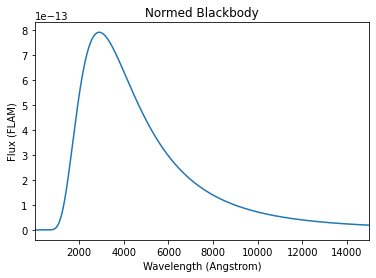

In [15]:
# First, create a blackbody at some temperature.
sp = SourceSpectrum(BlackBodyNorm1D, temperature=10000)
# sp.plot(left=1, right=15000, flux_unit='flam', title='Blackbody')

# Get the Vega spectrum as the zero point flux.
vega = SourceSpectrum.from_vega()
# vega.plot(left=1, right=15000)

# Normalize the blackbody to some chosen magnitude, say V = 10.
vmag = 10.
v_band = SpectralElement.from_filter('johnson_v')
sp_norm = sp.normalize(vmag * units.VEGAMAG, v_band, vegaspec=vega)
sp_norm.plot(left=1, right=15000, flux_unit='flam', title='Normed Blackbody')

Now we initialize the extinction model and choose an extinction of $A_V$ = 2.  To get the `dust_extinction` model working with `synphot`, we create a wavelength array and make a spectral element with the extinction model as a lookup table.

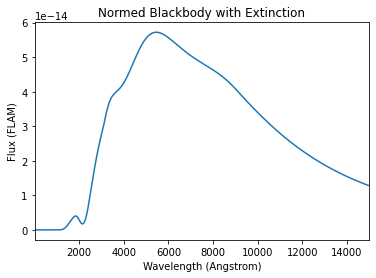

In [16]:
# Initialize the extinction model and choose the extinction, here Av = 2.
ext = CCM89(Rv=3.1)
Av = 2.

# Create a wavelength array. 
wav = np.arange(0.1, 3, 0.001)*u.micron

# Make the extinction model in synphot using a lookup table.
ex = ExtinctionCurve(ExtinctionModel1D, 
                     points=wav, lookup_table=ext.extinguish(wav, Av=Av))
sp_ext = sp_norm*ex
sp_ext.plot(left=1, right=15000, flux_unit='flam',
            title='Normed Blackbody with Extinction')

Synthetic photometry refers to modeling an observation of a star by multiplying the theoretical model for the astronomical flux through a certain filter response function, then integrating.

In [17]:
# "Observe" the star through the filter and integrate to get photometric mag.
sp_obs = Observation(sp_ext, v_band)
sp_obs_before = Observation(sp_norm, v_band)
# sp_obs.plot(left=1, right=15000, flux_unit='flam',
#             title='Normed Blackbody with Extinction through V Filter')

Next, `synphot` performs the integration and computes magnitudes in the Vega system.

In [18]:
sp_stim_before = sp_obs_before.effstim(flux_unit='vegamag', vegaspec=vega)
sp_stim = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega)
print('before dust, V =', np.round(sp_stim_before,1))
print('after dust, V =', np.round(sp_stim,1))

# Calculate extinction and compare to our chosen value.
Av_calc = sp_stim - sp_stim_before
print('$A_V$ = ', np.round(Av_calc,1))

before dust, V = 10.0 VEGAMAG
after dust, V = 12.0 VEGAMAG
$A_V$ =  2.0 VEGAMAG


This is a good check for us to do.  We normalized our spectrum to $V$ = 10 mag and added 2 mag of visual extinction, so the synthetic photometry procedure should reproduce these chosen values, and it does.  Now we are ready to find the extinction in other passbands. 

We calculate the new photometry for the rest of the Johnson optical and the Bessell infrared filters. We calculate extinction $A = \Delta m$ and plot color excess, $E(\lambda - V) = A_\lambda - A_V$.  

Notice that `synphot` calculates the effective wavelength of the observations for us, which is very useful for plotting the results.  We show reddening with the model extinction curve for comparison in the plot.

3601.5 Angstrom , 1.12 VEGAMAG
4368.9 Angstrom , 0.63 VEGAMAG
5463.8 Angstrom , 0.0 VEGAMAG


6810.6 Angstrom , -0.48 VEGAMAG
8619.6 Angstrom , -0.97 VEGAMAG


12266.5 Angstrom , -1.43 VEGAMAG
16351.9 Angstrom , -1.65 VEGAMAG
21956.7 Angstrom , -1.79 VEGAMAG


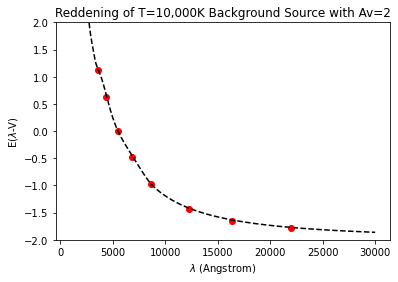

In [19]:
bands = [u_band,b_band,v_band,r_band,i_band,j_band,h_band,k_band]

for band in bands:
    # Calculate photometry with dust:
    sp_obs = Observation(sp_ext, band, force='extrap')
    obs_effstim = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega)
    # Calculate photometry without dust:
    sp_obs_i = Observation(sp_norm, band, force='extrap')
    obs_i_effstim = sp_obs_i.effstim(flux_unit='vegamag', vegaspec=vega)
  
    # Extinction = mag with dust - mag without dust
    # Color excess = extinction at lambda - extinction at V
    color_excess = obs_effstim - obs_i_effstim - Av_calc
    plt.plot(sp_obs_i.effective_wavelength(), color_excess,'or')
    print(np.round(sp_obs_i.effective_wavelength(),1), ',', 
          np.round(color_excess,2))

# Plot the model extinction curve for comparison 
plt.plot(wav,Av*ext(wav)-Av,'--k')
plt.ylim([-2,2])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('E($\lambda$-V)')
plt.title('Reddening of T=10,000K Background Source with Av=2')
plt.show()  

## Exercise
Try changing the blackbody temperature to something very hot or very cool.  Are the color excess values the same?  Have the effective wavelengths changed?

Note that the photometric extinction changes because the filter transmission is not uniform. The observed throughput of the filter depends on the shape of the background source flux.